# Introduction (SemEval Project)

* The task is to predict the perceived emotion(s) of a speaker based on a given text snippet. Specifically, I aim to identify whether any of the following emotions apply: joy, sadness, fear, anger, surprise, or disgust.

* This task is focusing on multi-label classification of text. Emotion recognition goes beyond identifying the emotion of the text itself, aiming to infer what the speaker is truly feeling.

In this project, I will:

* Download and preprocess the dataset, which requires signing up to the Codabench platform, as the dataset is not public.
* Explore the dataset, which is available in multiple languages, to decide whether to work with a single language or build a multilingual model.
* Experiment with BERT and its variants (RoBERTa, ALBERT, etc.), adapting them to output class labels by adding a classification head.
* Evaluate model performance using the F-score, the competition's metric, and propose an additional metric comparing model predictions against human performance.
* Conduct explainability analysis using SHAP to better understand the model's predictions.

In [55]:
# Installing additional libraries for text preprocessing
%pip install emoji
%pip install contractions
%pip install seaborn
%pip install spacy


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import json
from pprint import pprint

# Visualization libraries
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

# Text processing libraries
import emoji
import re
import contractions
from collections import Counter

# Install spacy if not already installed
%pip install spacy

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: spacy in c:\python312\lib\site-packages (3.8.3)




[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Spliting the data and look into the content

In [88]:
# Load the train and test files
train_df = pd.read_csv('D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/semeval_project/data/eng_train.csv')
test_df = pd.read_csv('D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/semeval_project/data/eng_a_dev.csv')

# Display the first few rows of the train dataframe
train_df.head()

# display dev data
#test_df.head()

# check the missing values in the train data
#train_df.isnull().sum()
# print number of missing values in the train data
#print('Number of missing values in the train data:', train_df.isnull().sum().sum())

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,Well she's not gon na last the whole song like...,0,0,1,0,0
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to mo...,0,0,0,0,0
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0


Data cleaning

In [89]:
# Perform data cleaning
def clean_data(df):
    # Remove any duplicate rows based on 'id'
    df = df.drop_duplicates(subset='id')

    # Fill any missing values in the emotion columns with 0
    emotion_columns = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
    df[emotion_columns] = df[emotion_columns].fillna(0)

    return df


# Clean the train and test dataframes
clean_train_df = clean_data(train_df)
#clean_test_df = clean_data(test_df)

# Replace column names with lowercase
clean_train_df.columns = [col.lower() for col in clean_train_df.columns]
#clean_test_df.columns = [col.lower() for col in clean_test_df.columns]

# Display the cleaned train dataframe
clean_train_df.head()

,id,text,anger,fear,joy,sadness,surprise
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,Well she's not gon na last the whole song like...,0,0,1,0,0
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to mo...,0,0,0,0,0
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0


Checking the data size and total number of samples

In [90]:
# Number of samples in the train dataset
num_train_samples = clean_train_df.shape[0]

# Number of samples in the test dataset
#num_test_samples = clean_test_df.shape[0]

# Total number of samples
total_samples = num_train_samples + test_df.shape[0]

print(f"Number of samples in the train dataset: {num_train_samples}")
#print(f"Number of samples in the test dataset: {num_test_samples}")
print(f"Total number of samples: {total_samples}")

Number of samples in the train dataset: 2768
Total number of samples: 2884


In [64]:
# Assuming you have already cleaned the data and defined the number of samples
num_train_samples = clean_train_df.shape[0]
num_test_samples = test_df.shape[0]
total_samples = num_train_samples + num_test_samples

# Print the shape of train, validation, and test datasets
print("Train dataset has {} samples and represents {:.2f}% of overall data".format(num_train_samples, num_train_samples / total_samples * 100))
print("Test dataset has {} samples and represents {:.2f}% of overall data".format(num_test_samples, num_test_samples / total_samples * 100))
print()
print("The total number of samples is : {}".format(total_samples))

Train dataset has 2768 samples and represents 95.98% of overall data
Test dataset has 116 samples and represents 4.02% of overall data

The total number of samples is : 2884


In [65]:
# Display some useful information about our data
clean_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2768 non-null   object
 1   text      2768 non-null   object
 2   anger     2768 non-null   int64 
 3   fear      2768 non-null   int64 
 4   joy       2768 non-null   int64 
 5   sadness   2768 non-null   int64 
 6   surprise  2768 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 151.5+ KB


# Text Preprocessing

In [66]:
# Visualising a random text sample from the dataset
text_sample = np.random.randint(len(clean_train_df))
print(clean_train_df.loc[text_sample, "text"])

My left clav essentially blew up, but it didn't stop there.


In [67]:
# Building a preprocessing function to clean text
def preprocess_data(x):

  # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
  x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)

  # Demojize
  x = emoji.demojize(x)

  # Expand contraction
  x = contractions.fix(x)

  # Lower
  x = x.lower()

  #correct some acronyms/typos/abbreviations
  x = re.sub(r"\b(yikes\b)", "worried", x)
  x = re.sub(r"\b(TV\b)", "Television", x)
  x = re.sub(r"\b(W910i\b)", "electronic gadget", x)
  x = re.sub(r"amirite", "am i right", x)
  x = re.sub(r"\b(tho)\b", "though", x)
  x = re.sub(r"\b(ikr)\b", "i know right", x) 
  x = re.sub(r"\b(ya|u)\b", "you", x)
  x = re.sub(r"\b(eu)\b", "europe", x)
  x = re.sub(r"\b(da)\b", "the", x)
  x = re.sub(r"\b(dat)\b", "that", x)
  x = re.sub(r"\b(dats)\b", "that is", x)
  x = re.sub(r"\b(cuz)\b", "because", x)
  x = re.sub(r"\b(fkn)\b", "fucking", x)
  x = re.sub(r"\b(tbh)\b", "to be honest", x)
  x = re.sub(r"\b(tbf)\b", "to be fair", x)
  x = re.sub(r"faux pas", "mistake", x)
  x = re.sub(r"\b(btw)\b", "by the way", x)
  x = re.sub(r"lmao", "laughing my ass off", x)
  x = re.sub(r"\b(bs)\b", "bullshit", x)
  x = re.sub(r"\b(kinda)\b", "kind of", x)
  x = re.sub(r"\b(bruh)\b", "bro", x)
  x = re.sub(r"\b(w/e)\b", "whatever", x)
  x = re.sub(r"\b(w/)\b", "with", x)
  x = re.sub(r"\b(w/o)\b", "without", x)
  x = re.sub(r"\b(doj)\b", "department of justice", x)
  

  #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
  x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
  x = re.sub(r"\b(co+l+)\b", "cool", x)
  x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
  x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
  x = re.sub(r"\b(o+m+g+)\b", "omg", x)
  x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
  x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
  x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
  x = re.sub(r"\b(w+o+w+)\b", "wow", x)
  x = re.sub(r"\b(w+h+y+)\b", "why", x)
  x = re.sub(r"\b(s+o+)\b", "so", x)
  x = re.sub(r"\b(f)\b", "fuck", x)
  x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
  x = re.sub(r"\b(ofc)\b", "of course", x)
  x = re.sub(r"\b(the us)\b", "usa", x)
  x = re.sub(r"\b(gf)\b", "girlfriend", x)
  x = re.sub(r"\b(hr)\b", "human ressources", x)
  x = re.sub(r"\b(mh)\b", "mental health", x)
  x = re.sub(r"\b(idk)\b", "i do not know", x)
  x = re.sub(r"\b(gotcha)\b", "i got you", x)
  x = re.sub(r"\b(y+e+p+)\b", "yes", x)
  x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
  x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
  x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
  x = re.sub(r"\b(o+h+)\b", "oh", x)
  x = re.sub(r"\b(a+h+)\b", "ah", x)
  x = re.sub(r"\b(u+h+)\b", "uh", x)

  # Handling emojis
  x = re.sub(r"<3", " love ", x)
  x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
  x = re.sub(r":\)", " smiling_face ", x)
  x = re.sub(r"^_^", " smiling_face ", x)
  x = re.sub(r"\*_\*", " star_struck ", x)
  x = re.sub(r":\(", " frowning_face ", x)
  x = re.sub(r":\^\(", " frowning_face ", x)
  x = re.sub(r";\(", " frowning_face ", x)
  x = re.sub(r":\/",  " confused_face", x)
  x = re.sub(r";\)",  " wink", x)
  x = re.sub(r">__<",  " unamused ", x)
  x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
  x = re.sub(r"\b(n+a+h+)\b", "no", x)

  # Handling special cases of text
  x = re.sub(r"h a m b e r d e r s", "hamberders", x)
  x = re.sub(r"b e n", "ben", x)
  x = re.sub(r"s a t i r e", "satire", x)
  x = re.sub(r"y i k e s", "yikes", x)
  x = re.sub(r"s p o i l e r", "spoiler", x)
  x = re.sub(r"thankyou", "thank you", x)
  x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

  # Remove special characters and numbers replace by space + remove double space
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^A-Za-z!?_]+"," ", x)
  x = re.sub(r"\b([s])\b *","", x)
  x = re.sub(r" +"," ", x)
  x = x.strip()

  return x

In [68]:
# Applying the preprocessing function on the dataset
clean_train_df["clean_text"] = clean_train_df["text"].apply(preprocess_data)

# Preview of data
display(clean_train_df[['text', 'clean_text']].sample(5))

,text,clean_text
233,Fast forward a year to beginning of hs this ye...,fast forward a year to beginning of hs this year
461,A strangely calming breeze crosses my face and...,a strangely calming breeze crosses my face and...
2479,I drain the last of my beer and the wrap my ar...,i drain the last of my beer and the wrap my ar...
1347,Not too bad but never really clicked.,not too bad but never really clicked
1001,"""Perhaps I'll alter the whole thing.",perhaps i will alter the whole thing


In [69]:
# Dropping raw text column
df_all = clean_train_df[ ['clean_text'] + [ col for col in clean_train_df.columns if col not in ['text', 'clean_text'] ] ]

# Preview of data
display(df_all.head(3))

,clean_text,id,anger,fear,joy,sadness,surprise
0,but not very happy,eng_train_track_a_00001,0,0,1,1,0
1,well she is not gon na last the whole song lik...,eng_train_track_a_00002,0,0,1,0,0
2,she sat at her papa recliner sofa only to move...,eng_train_track_a_00003,0,0,0,0,0


# Exploratory Data Analysis

In [70]:
# Define the sizes for train, validation, and test sets
size_train = int(0.8 * len(df_all))
size_val = int(0.1 * len(df_all))
size_test = len(df_all) - size_train - size_val

# Building a function that will divide in train, validation and test sets
def get_train_val_test(df):
    train = df.iloc[:size_train, :]
    val = df.iloc[size_train:size_train+size_val, :]
    test = df.iloc[size_train+size_val:size_train+size_val+size_test, :]
    return train, val, test

In [71]:
# Dividing back in train, validation and test datasets
train_data, val_data, test_data = get_train_val_test(df_all)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2214, 7)
(276, 7)
(278, 7)


In [72]:
# # Preview of data
display(train_data.head(5))

,clean_text,id,anger,fear,joy,sadness,surprise
0,but not very happy,eng_train_track_a_00001,0,0,1,1,0
1,well she is not gon na last the whole song lik...,eng_train_track_a_00002,0,0,1,0,0
2,she sat at her papa recliner sofa only to move...,eng_train_track_a_00003,0,0,0,0,0
3,yes the oklahoma city bombing,eng_train_track_a_00004,1,1,0,1,1
4,they were dancing to bolero,eng_train_track_a_00005,0,0,1,0,0


In [73]:
# Define Emotions as the list of emotion columns
emotions = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# Computing the number of labels for each sample
train_data['Cardinality'] = train_data.loc[:,emotions].apply(lambda x: sum(x), axis=1)

# Preview of data
display(train_data.head(3))

C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\1304113005.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Cardinality'] = train_data.loc[:,emotions].apply(lambda x: sum(x), axis=1)


,clean_text,id,anger,fear,joy,sadness,surprise,Cardinality
0,but not very happy,eng_train_track_a_00001,0,0,1,1,0,2
1,well she is not gon na last the whole song lik...,eng_train_track_a_00002,0,0,1,0,0,1
2,she sat at her papa recliner sofa only to move...,eng_train_track_a_00003,0,0,0,0,0,0


In [74]:
# Possible number of emotions per sample in our dataset
train_data['Cardinality'].value_counts()

Cardinality
1    908
2    842
3    233
0    185
4     45
5      1
Name: count, dtype: int64

Number of Emotions per sample in the dataset

C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\3350011012.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Cardinality', data=train_data, palette='Spectral')


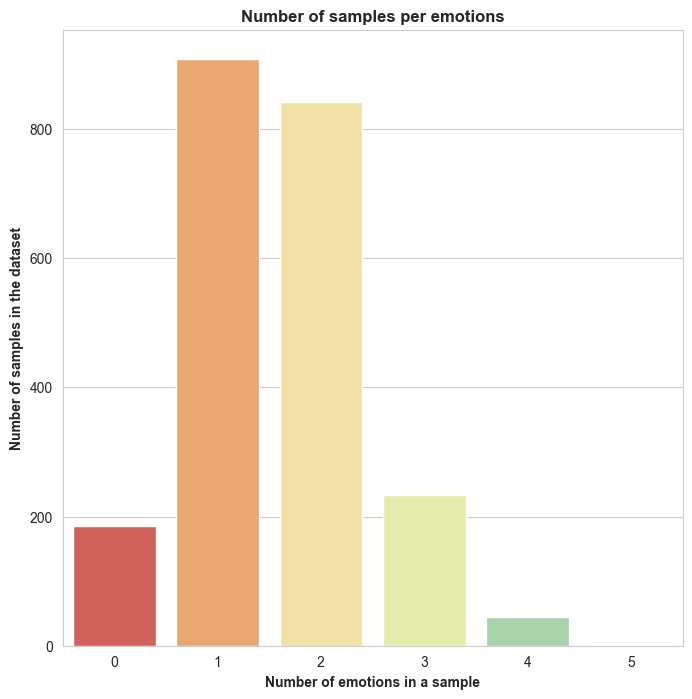

In [75]:
# Cardinality of Emotions and labels across the dataset
plt.figure(figsize=(8,8))

ax = sns.countplot(x='Cardinality', data=train_data, palette='Spectral')

for p in ax.patches:
  value = p.get_height()
  x = p.get_x() + p.get_width() - 0.5
  y = p.get_y() + p.get_height() + 1000
  ax.annotate(value, (x, y))


plt.title("Number of samples per emotions", fontweight='bold')
plt.ylabel("Number of samples in the dataset", fontweight='bold')
plt.xlabel("Number of emotions in a sample", fontweight='bold')
plt.show()


In [78]:
# Computing number of samples per emotion
classes_GE_count = train_data.loc[:,emotions].sum(axis=0).sort_values(ascending=False)

C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\3459641441.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=classes_GE_count.values, y=classes_GE_count.index, orient='h', palette="viridis")


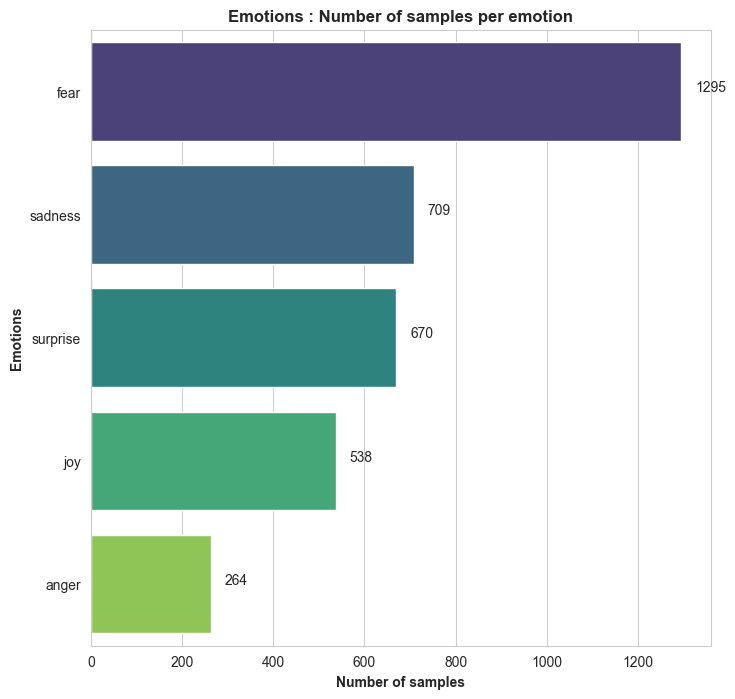

In [86]:
# Visualizing the number of samples per classes
plt.figure(figsize=(8,8))
ax = sns.barplot(x=classes_GE_count.values, y=classes_GE_count.index, orient='h', palette="viridis")

for p in ax.patches:
  value = int(p.get_width())
  x = p.get_x() + p.get_width() + 30
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("Emotions : Number of samples per emotion", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Number of samples", fontweight='bold')
plt.savefig('D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/semeval_project/figures/emotions.png')
plt.show()

# save this figure in pdf format
#plt.savefig('D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/semeval_project/figures/num_samples_per_emotion.pdf')




In [42]:
# Write the graph analysis (checkkkk)
# Number of samples per emotion in the dataset
with open('graph_analysis.txt', 'w') as f:
    f.write("Number of samples per emotion in the dataset\n")
    f.write("=============================================\n")
    f.write("\n")
    f.write("The number of samples per emotion in the GoEmotions dataset are as follows:\n")
    f.write("\n")
    f.write(f"Anger: {classes_GE_count['anger']}\n")
    f.write(f"Fear: {classes_GE_count['fear']}\n")
    f.write(f"Joy: {classes_GE_count['joy']}\n")
    f.write(f"Sadness: {classes_GE_count['sadness']}\n")
    f.write(f"Surprise: {classes_GE_count['surprise']}\n")
    f.write("\n")


Classe balance accross train, validation and test datasets

In [46]:
# Defining classes representation for each dataset
train_count_GE = (train_data.loc[:, emotions].sum(axis=0) / size_train)*100
val_count_GE = (val_data.loc[:, emotions].sum(axis=0) / size_val)*100
test_count_GE = (test_data.loc[:, emotions].sum(axis=0) / size_test)*100

# Constructing a unique dataset for visualization purposes
balance_GE = pd.DataFrame(data=[train_count_GE, val_count_GE, test_count_GE]).T.reset_index(drop=False)
balance_GE.columns = ['Emotion', 'Train', 'Validation', 'Test']
balance_GE = balance_GE.sort_values('Train', ascending=False)
balance_GE = balance_GE.melt(id_vars='Emotion', var_name='Dataset', value_vars=['Train','Validation', 'Test'], value_name='Percentage')

# Preview of data
display(balance_GE.head())

,Emotion,Dataset,Percentage
0,fear,Train,58.491418
1,sadness,Train,32.023487
2,surprise,Train,30.261969
3,joy,Train,24.299910
4,anger,Train,11.924119


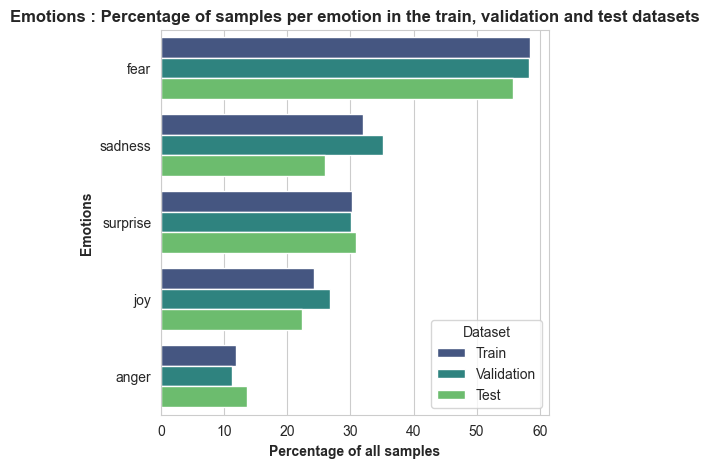

In [48]:
# Classe Balance visualization on Emotions
plt.figure(figsize=(5,5))
sns.barplot(x='Percentage', y='Emotion', data=balance_GE, orient='h', hue='Dataset', palette="viridis")
plt.title("Emotions : Percentage of samples per emotion in the train, validation and test datasets", fontweight='bold')
plt.ylabel("Emotions", fontweight='bold')
plt.xlabel("Percentage of all samples", fontweight='bold')
plt.show()

Word Analysis

In [50]:
# Mean length of samples per emotion
# Computing the number of words per sample
train_data['Nb_words'] = train_data['clean_text'].apply(lambda x: len(x.split()))

# Preview of data
display(train_data.head(3))

C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\2828727947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Nb_words'] = train_data['clean_text'].apply(lambda x: len(x.split()))


,clean_text,id,anger,fear,joy,sadness,surprise,Cardinality,Nb_words
0,but not very happy,eng_train_track_a_00001,0,0,1,1,0,2,4
1,well she is not gon na last the whole song lik...,eng_train_track_a_00002,0,0,1,0,0,1,42
2,she sat at her papa recliner sofa only to move...,eng_train_track_a_00003,0,0,0,0,0,0,19


In [51]:
# Computing the mean number of words per emotion
mean_nb_words = {}
for emo in emotions:
  nb = train_data['Nb_words'].loc[train_data[emo]==1].mean()
  mean_nb_words[emo] = round(nb,2)

# Putting it in a Dataframe
df_length_emo = pd.DataFrame.from_dict(mean_nb_words, orient='index')
df_length_emo.columns = ['Mean_length']
df_length_emo.sort_values('Mean_length', ascending=False, inplace=True)

df_length_emo.head()

,Mean_length
joy,16.63
fear,16.19
sadness,16.01
anger,14.79
surprise,14.08


Mean leangth per emotion

C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\1288132093.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_length_emo['Mean_length'], y=df_length_emo.index, orient='h', palette="flare")


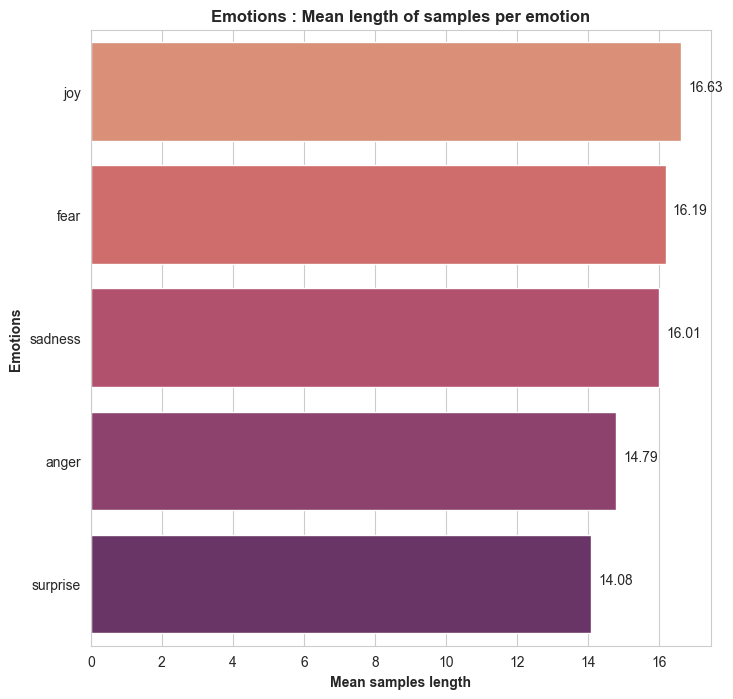

In [52]:
# Visualizing the mean length of samples per emotion
plt.figure(figsize=(8,8))

ax = sns.barplot(x=df_length_emo['Mean_length'], y=df_length_emo.index, orient='h', palette="flare")
for p in ax.patches:
  value = p.get_width()
  x = p.get_x() + p.get_width() + 0.2
  y = p.get_y() + p.get_height()/2
  ax.annotate(value, (x, y))

plt.title("Emotions : Mean length of samples per emotion", fontweight='bold')
plt.ylabel("Emotions ", fontweight='bold')
plt.xlabel("Mean samples length", fontweight='bold')
plt.show()

Top words per emotion

In [53]:
# Function to display 10 most frequent words in a list of comments
def plot_top_words_barchart(comments, axes):

    comments = comments.str.split() # split each comment into a list of words
    comments = comments.values.tolist() # from pandas series to lists of words
    corpus = [word for sample in comments for word in sample if word not in list(STOP_WORDS)+["?","!","name"]] # giant corpus of words excluding special characters
    counter = Counter(corpus) # create a counter
    most = counter.most_common(10) # retrieve the 10 most frequent words

    # Plot the 10 top words and their frequencies
    most = [(word, count) for (word, count) in most]
    x, y = [], []
    for word, count in most[:10]:
      x.append(word)
      y.append(count)
    sns.barplot(x=y, y=x , ax=axes, palette="Set2")

C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\4103296638.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x , ax=axes, palette="Set2")
C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\4103296638.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x , ax=axes, palette="Set2")
C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\4103296638.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y, y=x , ax=axes, palette="Set2")
C:\Users\Prerana\AppData\Local\Temp\ipykernel_4648\4103296638.py:16: FutureWarning: 

Passing 

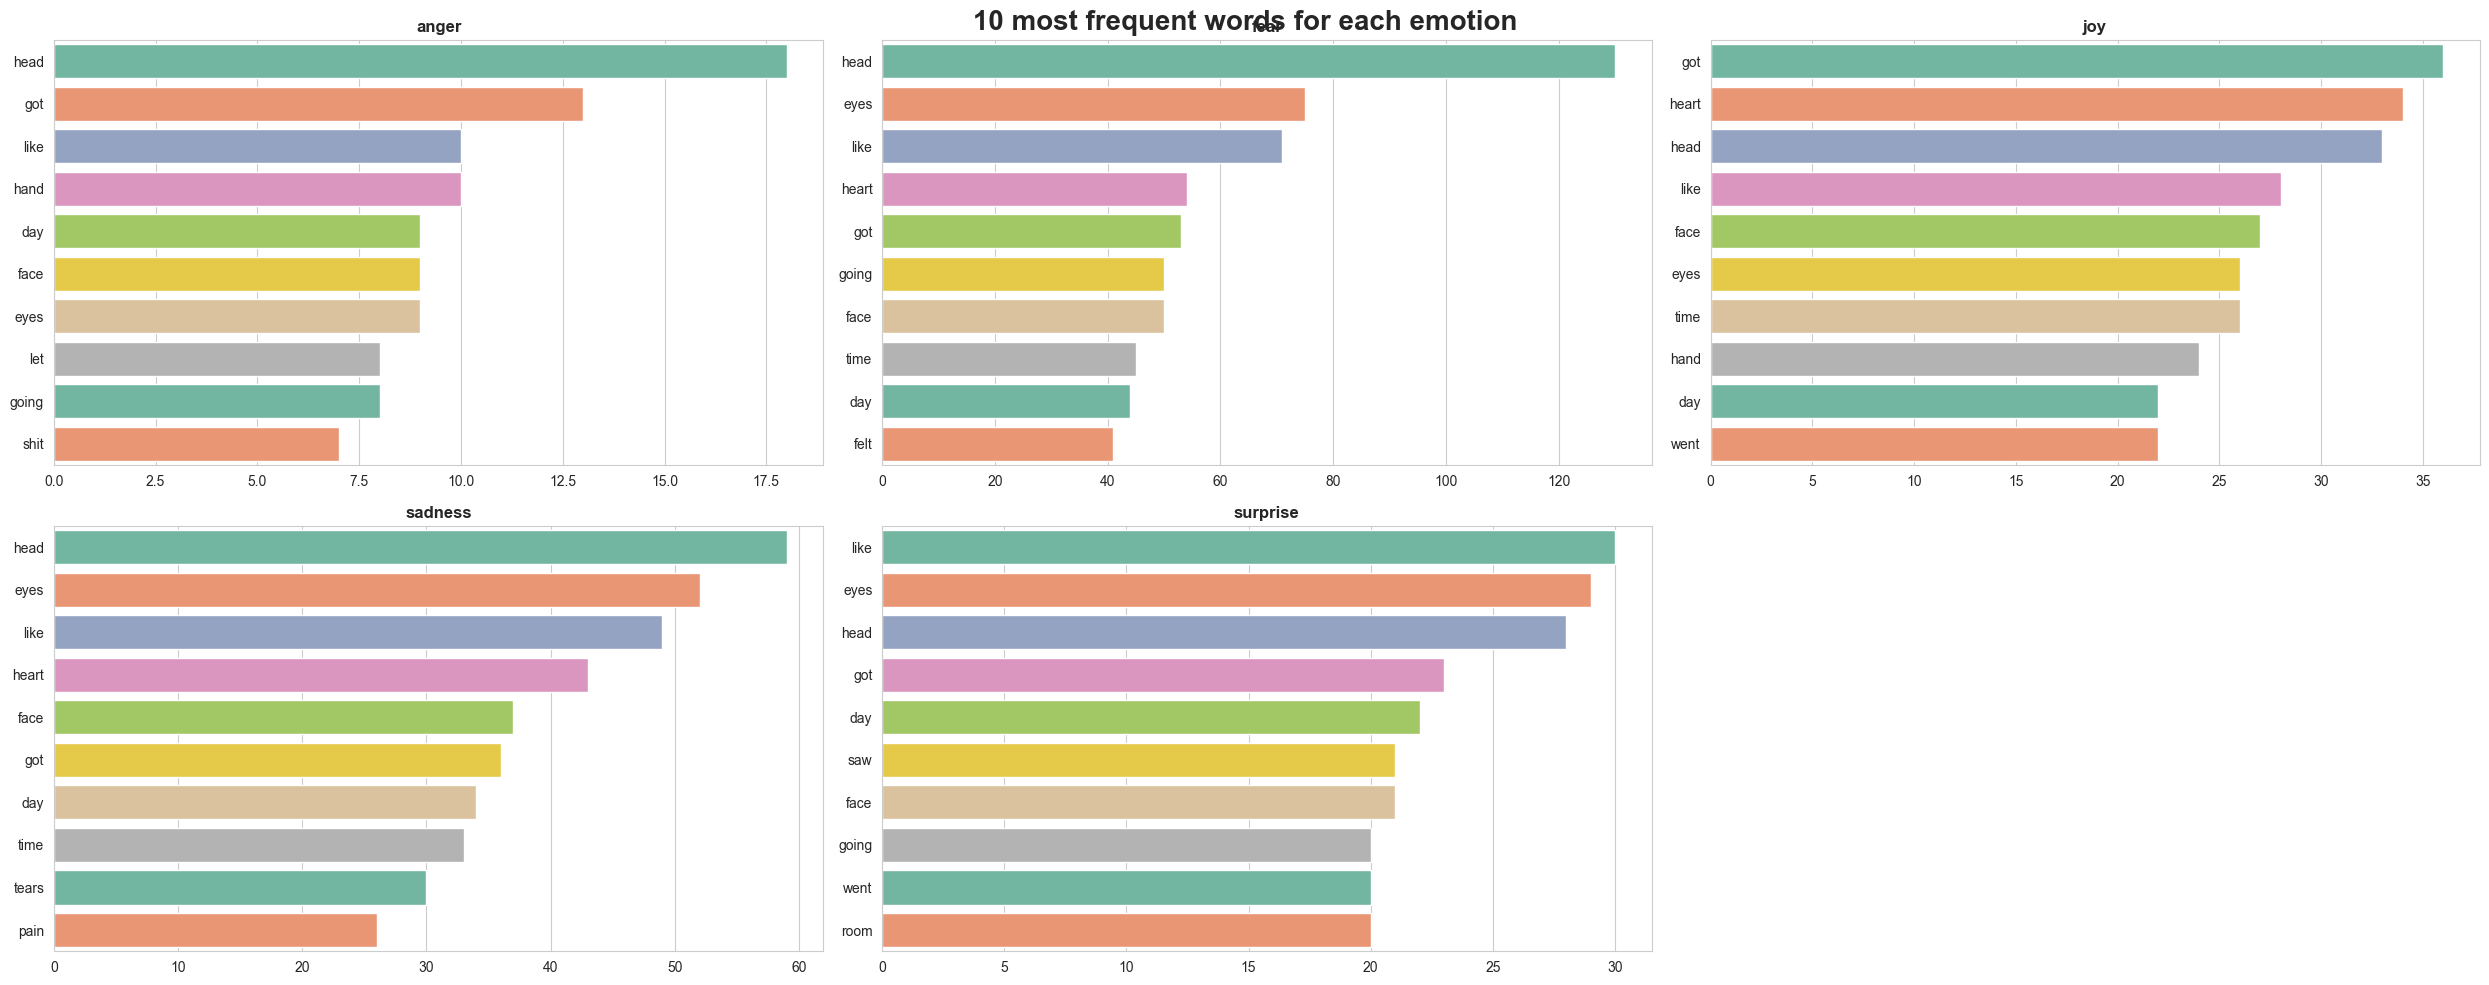

In [54]:
# Displaying 10 most frequent words for each emotion
fig, axes = plt.subplots(2, 3, figsize=(25, 10))  # Adjust the number of rows and columns as needed
fig.suptitle('10 most frequent words for each emotion', fontweight="bold", fontsize=20)

for i, axi in enumerate(axes.flat):
    if i < len(emotions):
        plot_top_words_barchart(train_data.loc[train_data[emotions[i]]==1,"clean_text"], axi)
        axi.set_title(emotions[i], fontweight="bold")
    else:
        axi.axis('off')  # Turn off the axis if there is no corresponding emotion

plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
# Exporting the data
# Droping unecessary columns
train_data = train_data[ ['clean_text'] + emotions ]

# Saving datasets for modeling
train_data.to_csv("D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/train_data.csv", index = False)
val_data.to_csv("D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/val_data.csv", index = False)
test_data.to_csv("D:/Drive D/TU_Dresden/STUDY/LLM/semeval_project/test_data.csv", index = False)